# Assignment 2

In [1]:
import torch
torch.cuda.empty_cache()
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode
from torchvision.models import resnet18, mobilenet_v2, MobileNet_V2_Weights
from transformers import DistilBertModel, DistilBertTokenizer, AdamW, AutoProcessor, get_scheduler, AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader, Dataset 

import sys
sys.path.append('/home/poz/Notebooks/645_Assignment2')
from CustomDataset import CustomDataset
from collate_fn import collate_fn

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageOps, Image
from tqdm import tqdm

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

import re
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

import multiprocessing
if __name__ == "__main__":
    import torch
    multiprocessing.set_start_method("spawn")
    torch.multiprocessing.set_sharing_strategy('file_system')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

print('CUDA available', torch.cuda.is_available())
print('CUDA version', torch.version.cuda)
print('cuDNN enabled', torch.backends.cudnn.enabled)
print('cuDNN version', torch.backends.cudnn.version())
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

n_cuda_devices = torch.cuda.device_count()
for i in range(n_cuda_devices):
    print(f'Device {i} name:', torch.cuda.get_device_name(i))

batch_size = 5
image_resize = 256 # 224
num_workers =0
num_epochs = 1
learning_rate=0.000001
stats = (torch.tensor([-0.1015, -0.1092, -0.0212]), torch.tensor([1.2459, 1.2227, 1.1827]))

transform = {
"train": transforms.Compose([
    transforms.Resize((image_resize, image_resize)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
]),
"val": transforms.Compose([
    transforms.Resize((image_resize, image_resize)),
    #transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
]),
"test": transforms.Compose([
    transforms.Resize((image_resize, image_resize)),
    #transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
]),}

data_dir = r"/home/poz/garbage_data"
train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
val_dir = os.path.join(data_dir, "CVPR_2024_dataset_Val")
test_dir = os.path.join(data_dir, "CVPR_2024_dataset_Test")

datasets = {"train": datasets.ImageFolder(train_dir, transform=transform["train"]),
            "val": datasets.ImageFolder(val_dir, transform=transform["val"]),
            "test": datasets.ImageFolder(test_dir, transform=transform["test"])}

class_names = datasets['train'].classes
print(class_names)

datasets = {"train": CustomDataset(datasets['train']),
            "val": CustomDataset(datasets['val']),
            "test": CustomDataset(datasets['test'])}

# Define the model and processor
model_id = 'microsoft/Florence-2-base-ft'
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch_dtype, trust_remote_code=True, revision='refs/pr/6').to(device)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True, revision='refs/pr/6') 

dataloaders = {"train": DataLoader(datasets["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=num_workers),
               "val": DataLoader(datasets["val"], batch_size=batch_size, collate_fn=collate_fn, shuffle=False, num_workers=num_workers),
               "test": DataLoader(datasets["test"], batch_size=batch_size, collate_fn=collate_fn, shuffle=False, num_workers=num_workers)}

print("Train set:", len(dataloaders['train'])*batch_size)
print("Val set:", len(dataloaders['val'])*batch_size)
print("Test set:", len(dataloaders['test'])*batch_size)

# Define the model and processor
model_id = 'microsoft/Florence-2-base-ft'
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch_dtype, trust_remote_code=True, revision='refs/pr/6').to(device)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True, revision='refs/pr/6') 

for param in model.vision_tower.parameters():
    param.is_trainable = False

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) 

# Training and Evaluation Loop
def train_model(train_loader, val_loader, model, processor, optimizer, epochs=num_epochs, lr=learning_rate):
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            i += 1
            inputs, classification = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"].to(device, dtype=torch.float16 if model.dtype == torch.float16 else torch.float32)
            labels = processor.tokenizer(text=classification, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, classification = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"].to(device, dtype=torch.float16 if model.dtype == torch.float16 else torch.float32)
                labels = processor.tokenizer(text=classification, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)
        
def main():
    train_model(dataloaders['train'], dataloaders['val'], model, processor, optimizer)

main()

2025-02-16 14:53:15.627506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739742795.639677   13715 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739742795.643446   13715 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 14:53:15.656298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


CUDA available True
CUDA version 12.4
cuDNN enabled True
cuDNN version 90100
PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
Device 0 name: NVIDIA GeForce RTX 2080 Ti
['Black', 'Blue', 'Green', 'TTR']


/home/poz/venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwi

Train set: 11630
Val set: 1800
Test set: 3435


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
Training Epoch 1/1: 100%|██████████| 2326/2326 [1:21:51<00:00,  2.11s/it]


Average Training Loss: nan


Validation Epoch 1/1: 100%|██████████| 360/360 [09:49<00:00,  1.64s/it]


Average Validation Loss: nan


In [1]:
import torch
torch.cuda.empty_cache()
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode
from torchvision.models import resnet18, mobilenet_v2, MobileNet_V2_Weights
from transformers import DistilBertModel, DistilBertTokenizer, AdamW, AutoProcessor, get_scheduler, AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader, Dataset 

import sys
sys.path.append('/home/poz/Notebooks/645_Assignment2')
# from CustomDataset import CustomDataset
# from read_text_files_with_labels import read_text_files_with_labels
# from collate_fn import collate_fn

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageOps, Image
from tqdm import tqdm

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

import re
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

print('CUDA available', torch.cuda.is_available())
print('CUDA version', torch.version.cuda)
print('cuDNN enabled', torch.backends.cudnn.enabled)
print('cuDNN version', torch.backends.cudnn.version())
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

n_cuda_devices = torch.cuda.device_count()
for i in range(n_cuda_devices):
    print(f'Device {i} name:', torch.cuda.get_device_name(i))

batch_size = 4
image_resize = 256 # 224
num_workers = 0
num_epochs = 1
max_len = 24
learning_rate=0.000001
stats = (torch.tensor([-0.1015, -0.1092, -0.0212]), torch.tensor([1.2459, 1.2227, 1.1827])) # get_dataset_stats(dataloaders['train'])

transform = {
"train": transforms.Compose([
    transforms.Resize((image_resize, image_resize)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
]),
"val": transforms.Compose([
    transforms.Resize((image_resize, image_resize)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
]),
"test": transforms.Compose([
    transforms.Resize((image_resize, image_resize)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
]),}

data_dir = r"/home/poz/garbage_data"
train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
val_dir = os.path.join(data_dir, "CVPR_2024_dataset_Val")
test_dir = os.path.join(data_dir, "CVPR_2024_dataset_Test")

datasets = {"train": datasets.ImageFolder(train_dir, transform=transform["train"]),
            "val": datasets.ImageFolder(val_dir, transform=transform["val"]),
            "test": datasets.ImageFolder(test_dir, transform=transform["test"])}

class_names = datasets['train'].classes
print(class_names)

class CustomDataset(Dataset):
    def __init__(self, image_dataset):
        self.image_dataset = image_dataset
        self.class_names = image_dataset.classes
        self.label_to_class_map = {i: self.class_names[i] for i in range(len(self.class_names))}
    def __len__(self):
        return len(self.image_dataset)
    def __getitem__(self, idx):
        image, label = self.image_dataset[idx]
        image_path = self.image_dataset.samples[idx][0]
        file_name_no_ext = os.path.splitext(os.path.basename(image_path))[0]
        text = "<GC>" + file_name_no_ext.replace('_', ' ')
        classification = self.label_to_class_map[label]
        return text, classification, image

datasets = {"train": CustomDataset(datasets['train']),
            "val": CustomDataset(datasets['val']),
            "test": CustomDataset(datasets['test'])}

# Define the model and processor
model_id = 'microsoft/Florence-2-base-ft'
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch_dtype, trust_remote_code=True, revision='refs/pr/6').to(device)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True, revision='refs/pr/6') 

for param in model.vision_tower.parameters():
    param.is_trainable = False

def collate_fn(batch):
    text, classification, image = zip(*batch)
    image = [img * 255 for img in image]
    inputs = processor(text=list(text), images=list(image), return_tensors="pt", padding=True).to(device)
    return inputs, classification

dataloaders = {"train": DataLoader(datasets["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=num_workers),
               "val": DataLoader(datasets["val"], batch_size=batch_size, collate_fn=collate_fn, shuffle=False, num_workers=num_workers),
               "test": DataLoader(datasets["test"], batch_size=batch_size, collate_fn=collate_fn, shuffle=False, num_workers=num_workers)}

print("Train set:", len(dataloaders['train'])*batch_size)
print("Val set:", len(dataloaders['val'])*batch_size)
print("Test set:", len(dataloaders['test'])*batch_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) 

# Training and Evaluation Loop
def train_model(train_loader, val_loader, model, processor, optimizer, epochs=num_epochs, lr=learning_rate):
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            i += 1
            inputs, classification = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"].to(device, dtype=torch.float16 if model.dtype == torch.float16 else torch.float32)
            labels = processor.tokenizer(text=classification, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, classification = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"].to(device, dtype=torch.float16 if model.dtype == torch.float16 else torch.float32)
                labels = processor.tokenizer(text=classification, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

train_model(dataloaders['train'], dataloaders['val'], model, processor, optimizer)

2025-02-16 20:51:25.198961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739764285.273113    2527 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739764285.293349    2527 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 20:51:25.482106: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


CUDA available True
CUDA version 12.4
cuDNN enabled True
cuDNN version 90100
PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
Device 0 name: NVIDIA GeForce RTX 2080 Ti
['Black', 'Blue', 'Green', 'TTR']


/home/poz/venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwi

Train set: 11632
Val set: 1800
Test set: 3432


Training Epoch 1/1: 100%|██████████| 2908/2908 [32:24<00:00,  1.50it/s]


Average Training Loss: nan


Validation Epoch 1/1: 100%|██████████| 450/450 [02:26<00:00,  3.07it/s]


Average Validation Loss: nan


In [6]:
def run_batch(inputs):
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"].to(device, dtype=torch.float16 if model.dtype == torch.float16 else torch.float32),
        max_new_tokens=4096,
        num_beams=5,
    )
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=False)
    return generated_texts

def evaluate_model(inputs, classification):
    task_prompt = "<GC>"
    generated_texts = run_batch(inputs)
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(
            inputs["pixel_values"].shape[-2],
            inputs["pixel_values"].shape[-1],
        ),
    )
    predicted_class = parsed_answer[task_prompt].replace("<pad>", "")
    return predicted_class
os.environ['TORCH_USE_CUDA_DSA'] = "1"
data_iter = iter(dataloaders["test"])
inputs, classification = next(data_iter)
print(f"This is your classification: {classification}")
print(f"This is your predicted classificatoin: {evaluate_model(inputs, classification)}")

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [4]:
from tqdm import tqdm

def run_batch(inputs):
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"].to(device, dtype=torch.float16 if model.dtype == torch.float16 else torch.float32),
        max_new_tokens=4096,
        num_beams=5,
    )
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=False)
    return generated_texts

def evaluate_model(test_loader):
    task_prompt = "<GC>"
    predictions = []
    ground_truth = []
    
    for inputs, classification in tqdm(test_loader, desc="Evaluating"):
        generated_texts = run_batch(inputs)
        
        for generated_text, true_class in zip(generated_texts, classification):
            parsed_answer = processor.post_process_generation(
                generated_text,
                task=task_prompt,
                image_size=(
                    inputs["pixel_values"].shape[-2],
                    inputs["pixel_values"].shape[-1],
                ),
            )
            predicted_class = parsed_answer[task_prompt].replace("<pad>", "")
            predictions.append(predicted_class)
            ground_truth.append(true_class)
    
    return predictions, ground_truth

# Example usage with your dataloader test
predictions, ground_truth = evaluate_model(dataloaders["test"])
for idx, (true_class, predicted_class) in enumerate(zip(ground_truth, predictions)):
    print(f"Sample {idx + 1}:")
    print(f"  True classification: {true_class}")
    print(f"  Predicted classification: {predicted_class}")

Evaluating:   0%|          | 0/858 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
def imshow(img, stats):
    mean = stats[0].view(3, 1, 1).to(img.device)  # Move mean to the same device as img
    std = stats[1].view(3, 1, 1).to(img.device)   # Move std to the same device as img
    img = img * std + mean
    npimg = img.cpu().numpy()  # Convert the tensor back to numpy after moving it to CPU
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

stats = (torch.tensor([-0.1015, -0.1092, -0.0212]), torch.tensor([1.2459, 1.2227, 1.1827]))

for i in range(5):  # Check the first 5 items
    text, classification, image = datasets['train'][i]
    print(f"Index: {i}")
    print(f"Text: {text}")
    print(f"Classification: {classification}")
    print(f"Image Shape: {image.shape}")
    imshow(image, stats)
    print("-" * 20)

In [2]:
def imshow(img, stats):
    mean = stats[0].view(3, 1, 1).to(img.device)  # Move mean to the same device as img
    std = stats[1].view(3, 1, 1).to(img.device)   # Move std to the same device as img
    img = img * std + mean
    npimg = img.cpu().numpy()  # Convert the tensor back to numpy after moving it to CPU
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for i in range(5):  # Check the first 5 items
    image, label = datasets['train'][i]
    print(f"Index: {i}")
    print(f"Label: {label}")
    print(f"Image Path: {datasets['train'].samples[i][0]}")
    print(f"Image Name: {os.path.splitext(os.path.basename(datasets['train'].samples[i][0]))[0].replace('_', ' ')}")
    print(f"Image Shape: {image.shape}")
    imshow(image, stats)
    print("-" * 20)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/poz/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_21504/2979436522.py", line 10, in <module>
    image, label = datasets['train'][i]
    ^^^^^^^^^^^^
ValueError: too many values to unpack (expected 2)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/poz/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 2170, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/poz/venv/lib/python3.12/site-packages/IPython/core/ultratb.py", line 1457, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/poz/venv/lib/python3.12/site-packages/IPython/core/ultratb.py", line 1348, in structured

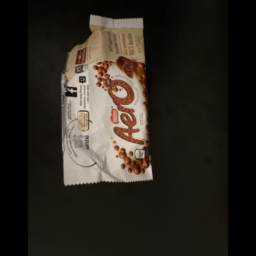

['Black', 'Blue', 'Green', 'TTR']


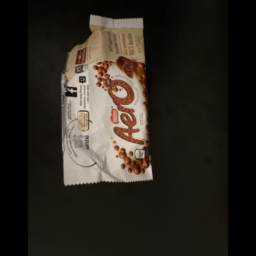

Pixel values before processing: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Pixel values after processing: tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         

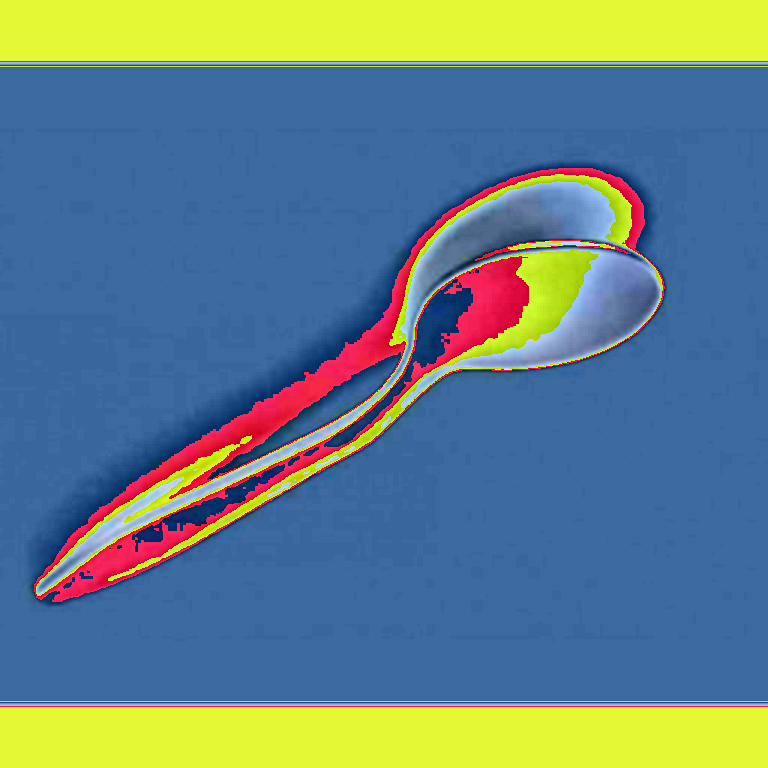

Image after processing


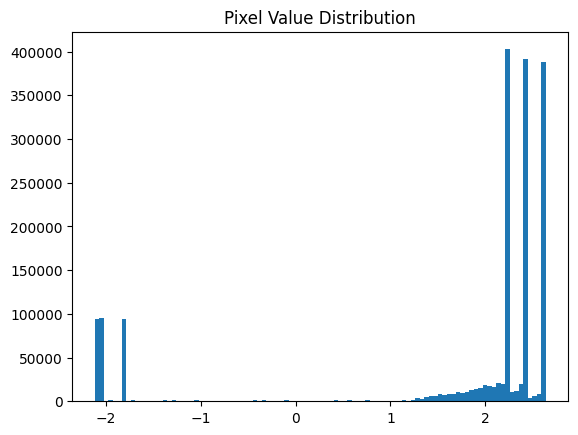

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


Pixel values after processing: tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8

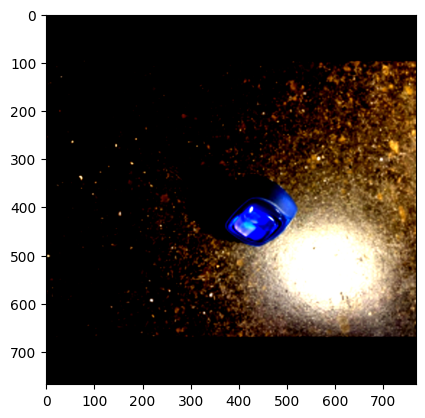

Pixel values after processing: tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8

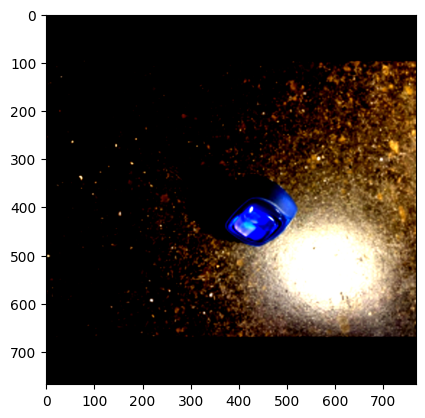

In [45]:
# import sys
# sys.path.append('/home/poz/Notebooks/645_Assignment2')
# from metrics import average_normalized_levenshtein_similarity

import torch
torch.cuda.empty_cache()
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode, ToPILImage
from torchvision.models import resnet18, mobilenet_v2, MobileNet_V2_Weights
from transformers import DistilBertModel, DistilBertTokenizer, AdamW, AutoProcessor, get_scheduler, AutoModelForCausalLM, AutoTokenizer, VisionEncoderDecoderModel, AutoConfig
from torch.utils.data import DataLoader, Dataset 

import sys
sys.path.append('/home/poz/Notebooks/645_Assignment2')
from CustomDataset import CustomDataset
from collate_fn import collate_fn

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageOps, Image
from tqdm import tqdm

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

import re
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

batch_size = 6
image_resize = 256 # 224
num_workers = 0
num_epochs = 1
max_len = 24
learning_rate=0.000001
stats = (torch.tensor([-0.1015, -0.1092, -0.0212]), torch.tensor([1.2459, 1.2227, 1.1827])) # get_dataset_stats(dataloaders['train'])

transform = {
"train": transforms.Compose([
    transforms.Resize((image_resize, image_resize)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    #transforms.Normalize(mean=stats[0].tolist(), std=stats[1].tolist())
]),
"val": transforms.Compose([
    transforms.Resize((image_resize, image_resize)),
    #transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    #transforms.Normalize(mean=stats[0].tolist(), std=stats[1].tolist())
]),
"test": transforms.Compose([
    transforms.Resize((image_resize, image_resize)),
    #transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    #transforms.Normalize(mean=stats[0].tolist(), std=stats[1].tolist())
]),}

data_dir = r"/home/poz/garbage_data"
train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
val_dir = os.path.join(data_dir, "CVPR_2024_dataset_Val")
test_dir = os.path.join(data_dir, "CVPR_2024_dataset_Test")

datasets = {"train": datasets.ImageFolder(train_dir, transform=transform["train"]),
            "val": datasets.ImageFolder(val_dir, transform=transform["val"]),
            "test": datasets.ImageFolder(test_dir, transform=transform["test"])}

image, _ = datasets["train"][0]
to_pil = ToPILImage()
image_pil = to_pil(image)
image_pil.show()

class_names = datasets['train'].classes
print(class_names)

class CustomDataset(Dataset):
    def __init__(self, image_dataset):
        self.image_dataset = image_dataset
        self.class_names = image_dataset.classes
        self.label_to_class_map = {i: self.class_names[i] for i in range(len(self.class_names))}
    def __len__(self):
        return len(self.image_dataset)
    def __getitem__(self, idx):
        image, label = self.image_dataset[idx]
        image_path = self.image_dataset.samples[idx][0]
        file_name_no_ext = os.path.splitext(os.path.basename(image_path))[0]
        text = "<GC>" + file_name_no_ext.replace('_', ' ')
        classification = self.label_to_class_map[label]
        return text, classification, image

datasets = {"train": CustomDataset(datasets['train']),
            "val": CustomDataset(datasets['val']),
            "test": CustomDataset(datasets['test'])}

text, classification, image = datasets["train"][0]
to_pil = ToPILImage()
image_pil = to_pil(image)
image_pil.show()
print("Pixel values before processing:", image)
def collate_fn(batch):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
    model_id = 'microsoft/Florence-2-base-ft'
    processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True, revision='refs/pr/6') 
    text, classification, image = zip(*batch)
    image = [img * 255 for img in image]
    inputs = processor(text=list(text), images=list(image), return_tensors="pt", padding=True).to(device)
    print("Pixel values after processing:", inputs['pixel_values'][0])
    return inputs, classification

dataloaders = {"train": DataLoader(datasets["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=num_workers),
               "val": DataLoader(datasets["val"], batch_size=batch_size, collate_fn=collate_fn, shuffle=False, num_workers=num_workers),
               "test": DataLoader(datasets["test"], batch_size=batch_size, collate_fn=collate_fn, shuffle=False, num_workers=num_workers)}

# data_iter = iter(dataloaders["train"])
# inputs, classification = next(data_iter)
# image = inputs['pixel_values']
# to_pil = ToPILImage()
# image_pil = to_pil(image[0])
# image_pil.show()

# Visualize image after processing
data_iter = iter(dataloaders["train"])
inputs, classification = next(data_iter)
image = inputs['pixel_values']

# Let's look at the raw pixel values
print("Raw pixel values after processing:", image[0])

to_pil = ToPILImage()
image_pil = to_pil(image[0].cpu())
image_pil.show()
print("Image after processing")

# Function to visualize pixel values
def visualize_pixel_values(img_tensor):
    img_numpy = img_tensor.cpu().numpy()
    plt.hist(img_numpy.flatten(), bins=100)
    plt.title("Pixel Value Distribution")
    plt.show()

# Visualize pixel values before and after processing
visualize_pixel_values(image[0])

# checkpoint_dir = "/home/poz/Notebooks/645_Assignment2/model_checkpoints/epoch_1"
# config = AutoConfig.from_pretrained('microsoft/Florence-2-base-ft')
# config.encoder = config.vision_config
# config.decoder = config.text_config
# model = VisionEncoderDecoderModel.from_pretrained(checkpoint_dir, config=config).to(device)
# processor = AutoProcessor.from_pretrained(checkpoint_dir)

def run_batch(inputs):
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"].to(device, dtype=torch.float16 if model.dtype == torch.float16 else torch.float32),
        max_new_tokens=4096,
        num_beams=5,
    )
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=False)
    return generated_texts


def evaluate_model(test_loader):
    task_prompt = "<GC>"
    predicted_answers = []
    ground_truth = []

    for inputs, classification in tqdm(test_loader, desc="Evaluating"):
        generated_texts = run_batch(inputs)

        for generated_text, classifications in zip(generated_texts, classification):
            parsed_answer = processor.post_process_generation(
                generated_text,
                task=task_prompt,
                image_size=(
                    inputs["pixel_values"].shape[-2],
                    inputs["pixel_values"].shape[-1],
                ),
            )
            predicted_class = parsed_answer[task_prompt].replace("<pad>", "")
            print(predicted_class)
            print(classifications)
            predicted_answers.append(predicted_class)
            ground_truth.append(classifications)
            # print("Ans:", parsed_answer[task_prompt])
            # print("GT:", answers)

    #avg_levenshtein_similarity = average_normalized_levenshtein_similarity(ground_truth, predicted_answers)
    return classifications#, avg_levenshtein_similarity
    
# def imshow(img, stats):
#     mean = stats[0].view(3, 1, 1).to(img.device)  # Move mean to the same device as img
#     std = stats[1].view(3, 1, 1).to(img.device)   # Move std to the same device as img
#     img = img * std + mean
#     npimg = img.cpu().numpy()  # Convert the tensor back to numpy after moving it to CPU
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

def imshow_altered(img, stats):
    # Extract the image tensor (pixel values) from the batch feature
    img = img['pixel_values']  # Assuming 'img' is a BatchFeature with 'pixel_values' key

    # Remove the batch dimension (assumes batch size is 1, or we can just display the first image in the batch)
    img = img[0]  # Access the first image in the batch (if there's only one image)

    # Normalize using the stats provided (mean and std)
    mean = stats[0].view(3, 1, 1).to(device)  # Ensure mean is on the correct device
    std = stats[1].view(3, 1, 1).to(device)   # Ensure std is on the correct device
    #img = img * std + mean  # Apply normalization
    #img = torch.clamp(img, 0, 1)
    # Convert the image to a suitable format for visualization (numpy array)
    img = img.permute(1, 2, 0).cpu().numpy()  # Change channel order (C, H, W) -> (H, W, C)

    # Rescale the image to the range [0, 1] for display
    img = np.clip(img, 0, 1)  # Ensure values are in the valid range for display
    plt.imshow(img)
    plt.show()

def imshow(img,stats):
    mean = stats[0].view(3, 1, 1).to(device)
    std = stats[1].view(3, 1, 1).to(device)
    #img = img * std + mean
    #img = torch.clamp(img, 0, 1)
    # to_pil = ToPILImage()
    # img = to_pil(img)
    # img.show()
    npimg = img.cpu().numpy() # convert the tensor back to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data_iter = iter(dataloaders["test"])
inputs, classification = next(data_iter)
image = inputs['pixel_values']
to_pil = ToPILImage()
image_pil = to_pil(image[0])
imshow(image[0], stats)

dataiter = iter(dataloaders['test'])
image, labels = next(dataiter)
imshow_altered(image, stats)

# Run the evaluation
#classifications = evaluate_model(dataloaders['test']) #, average_similarity 
#print(f"Average Normalized Levenshtein Similarity: {average_similarity:.4f}")
#classifications